# Analyzing intracranial electrophysiology data with xarray

```{post} 2019-10-22
:tags: analysis, neuroscience, xarray, open source
:redirect: xarray-explore-ieeg
```

Over the last few years, it has been exciting to see the xarray project evolve,
add new functionality, and mature. This post is an attempt at
giving xarray another visit to see how it could integrate into electrophysiology
workflows.

## A quick background on our data

It is common in neuroscience to ask individuals to perform a task over and over again. You record
the activity in the brain each time they perform the task (called an "epoch" or a "trial").
Time is recorded relative to some *onset* when the task begins. That is `t==0`. The result
is usually a matrix of `epochs x channejupyls x time`. You can do a lot of stuff with this
data, but our task in this paper is to detect changes in neural activity at trial onset (`t==0`).

In our case, we've got a small dataset from [an old paper of mine](https://www.frontiersin.org/articles/10.3389/fnsys.2017.00061/full).
The repository contains
several tutorial notebooks and sample data to describe predictive modeling
in cognitive neuroscience. [You can find the repository here](https://github.com/choldgraf/paper-encoding_decoding_electrophysiology). The task that individuals were performing was passively
listening to spoken sentences through a speaker. While they did this, we recorded electrical
activity at the surface of their brain (these were surgical patients, and had implanted electrodes
under their scalp).

In the [Feature Extraction](https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/notebooks/FeatureExtraction.ipynb) notebook,
I covered how to do some simple data manipulation and feature extraction with
timeseries analysis. Let's try to re-create some of the main steps in that tutorial,
but now using xarray as an in-memory structure for our data.

**Note**: The goal here is to learn a bit about xarray moreso than to discuss
ecog modeling, so I'll spend more time talking about my thoughts on the various
functions/methods/etc in Xarray than talking about neuroscience.

In this post, we'll perform a few common processing and extraction steps.
The goal is to do a few munging operations that require manipulating data
and visualizing simple statistics.

In [16]:
# Imports we'll use later
import mne
import numpy as np
import matplotlib.pyplot as plt
from download import download
import os
from sklearn.preprocessing import scale
import xarray as xr
xr.set_options(display_style="html")

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

We'll load the data from my GitHub repository (probably not the most efficient
way to store or retrieve the data, but hey, this was 3 years ago :-) ).

In [17]:
url_epochs = "https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/raw_data/ecog-epo.fif?raw=true"

path_data = download(url_epochs, './ecog-epo.fif', replace=True)
ecog = mne.read_epochs(path_data, preload=True)
os.remove(path_data)

file_sizes:   0%|                                   | 0.00/8.36M [00:00<?, ?B/s]

file_sizes: 100%|██████████████████████████| 8.36M/8.36M [00:00<00:00, 12.5MB/s]

Successfully downloaded file to ./ecog-epo.fif
Reading ./ecog-epo.fif ...


Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    5996.67 ms
        0 CTF compensation matrices available
29 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Here's what the raw data looks like - each horizontal line is electrical activity
in a channel over time. The faint vertical green lines show the onset of
each trial (they are concatenated together, but in reality there's a bit of time
between trials). This will be one of the last times we use MNE hopefully.

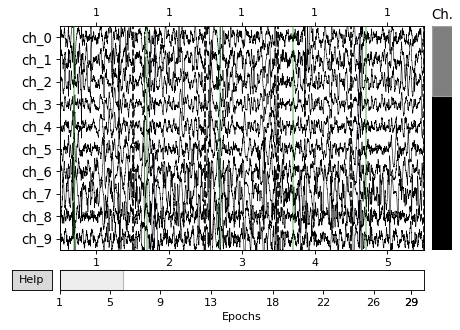

In [18]:
_ = ecog.plot(scalings='auto', n_epochs=5, n_channels=10)

# Converting to xarray

First off, we'll define a helper function that
converts the MNE Epochs object into an xarray DataArray object.
DataArrays provide an N-Dimensional representation of data, but with
the option to include a lot of extra metadata.

DataArrays are useful because you can include information
*about each dimension* of the data. For example, we can tell our
DataArray the name, values, and units of each dimension. In this case,
in our case one dimension is "time" so we can label it as such.

In [19]:
def epochs_to_dataarray(epochs):
    """A simple function to convert an Epochs object to DataArray"""
    da = xr.DataArray(
    epochs._data,
    dims=['epoch', 'channel', 'time'],
    coords={
        'time': ecog.times,
        'channel': ecog.ch_names,
        'epoch': range(ecog._data.shape[0])
    },
    name='Sample dataset',
    attrs=dict(ecog.info)
    )
    return da

Just look at all the metadata that we were able to pack into the DataArray.
Almost all of MNE's metadata fit nicely into `.attrs`. 

In [22]:
# There's quite a lot of output, so keep scrolling down!
da = epochs_to_dataarray(ecog)
da

<xarray.DataArray 'Sample dataset' (epoch: 29, channel: 32, time: 2250)>
array([[[-118.10999298, -121.30046844, -117.64116669, ...,
           20.78869057,   11.38018703,    8.12319088],
        [-126.95540619, -120.84265137, -105.75999451, ...,
           25.57149315,   28.6223793 ,   24.82316971],
        [ -28.1061306 ,  -16.39686775,  -21.64873505, ...,
          -31.78049469,  -24.28160286,  -25.21776772],
        ...,
        [  18.55451965,   22.87419701,   25.66038895, ...,
           25.84903336,   19.71798515,   14.92882633],
        [ -44.79590607,  -49.5848465 ,  -52.08906555, ...,
          -48.92469025,  -54.11177826,  -60.23026276],
        [-105.09076691, -108.88887024, -113.57571411, ...,
           -3.28264022,    5.5660615 ,   13.18798733]],

       [[  20.84839821,   18.30262566,   20.12442017, ...,
          -19.40711594,  -18.51371574,  -20.21596718],
        [  18.0386982 ,    5.35804272,   -6.45382166, ...,
          -42.1801033 ,  -44.59093857,  -47.80654144],
        [  76.62892914,   73.66176605,   64.21563721, ...,
          -12.31007576,  -21.26686478,  -26.83379555],
        ...,
        [  58.06867599,   53.49727631,   51.89107895, ...,
           42.84626007,   52.36317062,   55.75439453],
        [ -24.79452324,  -18.58691406,   -8.12459183, ...,
          -45.95447159,  -42.66623306,  -41.06335449],
        [-110.1750946 , -101.40830994,  -88.24209595, ...,
          -26.7741375 ,  -32.31249619,  -37.07465744]],

       [[  44.85819626,   57.10462952,   68.87900543, ...,
           13.73396015,   28.33650208,   40.76254654],
        [  10.10721684,   19.94246101,   31.81379509, ...,
          120.01114655,  119.50100708,  128.0358429 ],
        [ -96.35434723,  -89.9883194 ,  -72.41400909, ...,
          140.28143311,  131.52635193,  133.30158997],
        ...,
        [   1.81244755,   -1.55214143,   -2.54425907, ...,
          -30.9526062 ,  -31.50832367,  -32.25312042],
        [  44.95462799,   38.7992363 ,   33.4192009 , ...,
           64.5262146 ,   62.74245834,   61.11261368],
        [ -37.66891861,  -37.9514122 ,  -40.97248077, ...,
           61.204319  ,   58.57411194,   56.27007675]],

       ...,

       [[  88.75709534,   83.42398071,   76.10377502, ...,
          -23.7650528 ,  -23.43914986,  -19.55894852],
        [  63.89505005,   63.79450226,   61.43893433, ...,
          -54.35200119,  -59.907547  ,  -69.36830139],
        [  39.31270599,   46.15828705,   51.12403107, ...,
          -30.19447899,  -27.1382637 ,  -19.75760651],
        ...,
        [  -2.09485602,  -13.05238819,  -19.73264503, ...,
          150.31195068,  129.28895569,  114.28322601],
        [-142.40054321, -142.72599792, -140.20773315, ...,
           90.81705475,   82.73035431,   77.06429291],
        [-161.34713745, -160.04364014, -151.092453  , ...,
          238.87109375,  230.41633606,  222.64045715]],

       [[  67.85353088,   72.97834778,   70.99682617, ...,
           99.13801575,   95.14775085,   86.59616089],
        [ 169.86994934,  172.12055969,  173.22143555, ...,
          132.95147705,  135.66346741,  141.64862061],
        [  80.4973526 ,   77.63601685,   73.43898773, ...,
           91.37036896,   84.76886749,   82.48825836],
        ...,
        [ -13.24606895,   -8.65564728,    6.53395557, ...,
         -105.62326813, -104.58720398, -107.99065399],
        [  22.20972443,   49.33536148,   85.349823  , ...,
         -103.54721069, -102.84375   , -104.26371002],
        [ -33.03855133,   -9.5574255 ,   10.97984695, ...,
         -148.20103455, -148.95999146, -154.4241333 ]],

       [[ -98.52385712,  -99.22042847,  -99.56749725, ...,
           49.72173309,   41.6667099 ,   31.01161194],
        [ -70.90259552,  -66.83739471,  -68.66448975, ...,
           35.73180008,   33.55708694,   28.1260643 ],
        [ -29.78354645,  -34.5358963 ,  -40.23687363, ...,
          -39.39603043,  -42.75005341,  -50.70994186],
        ...,
        [ 110.57292175,  103.35498047,   95.09171295, ...,
     

The data consists of many trials, channels, and timepoints.
Let's start by selecting a time region within each trial that
we can visualize more cleanly.

# Subsetting out data with `da.sel`

In xarray, we select items with the `sel` and `isel` method. This
behaves kind of like the pandas `loc` and `iloc` methods, however
because we have named dimensions, we can directly specify them in
our call.

In [23]:
# We'll drop a subset of timepoints for visualization
da = da.sel(time=slice(-1, 3))

Now let's calculate the average across all epochs for each electrode/time point.
This is a **reduction** of our data array, in that it reduces the number of dimensions.
Xarray has many of the same statistical methods that NumPy does. An interesting
twist is that you can specify named dimensions instead of simply an `axis=<integer>`
argument. In addition, we'll choose the colors that we'll use for cycling through
our channels - because we can quickly reference the channels axis by name, we don't
need to remember which axis corresponds to channels.

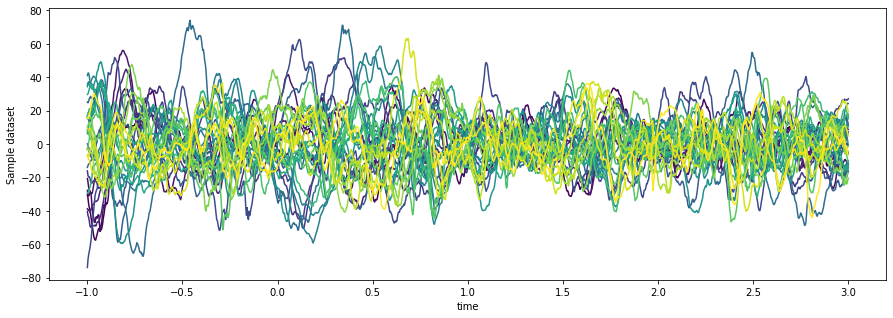

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
n_channels = da['channel'].shape[0]
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, n_channels)))
da.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

It doesn't look like much is going on...let's see if we can clean it up a bit.

# De-meaning the data with `da.where`

First off - we'll subtract the "pre-baseline mean" from each trial.
This makes it easier to visualize how each channel's activity *changed*
at time == 0.

To accomplish this we'll use `da.where`. This takes some kind of
boolean-style mask, does a bunch of clever projections according to the
names of coordinates, and returns the dataarray masked values removed
(as `NaN`s) and other values unchanged. We can use this to calculate the
mean of each channel / epoch *only for the pre-baseline timepoints*.

In [25]:
# This returns a version of the data array with NaNs where the query is False
# The dimensions will intelligently broadcast 
prebaseline_mean = da.where(da.time < 0).mean(dim='time')
da_demeaned = da - prebaseline_mean

Now we can visualize the de-baseline-meaned data

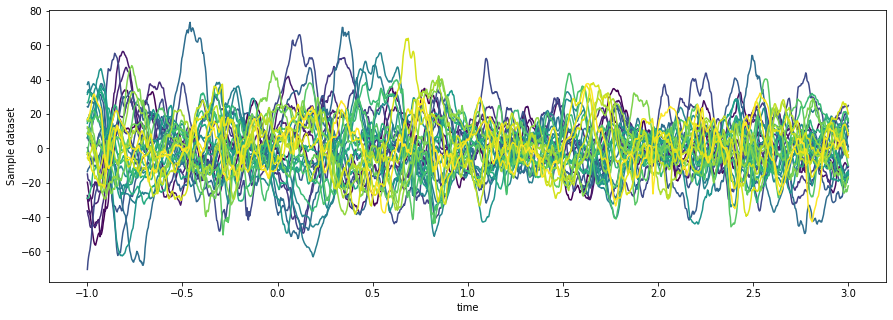

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, da['channel'].shape[0])))
da_demeaned.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

Hmmm, there still doesn't seem to be much going on (that channel down
at the bottom looks noisy to me, rather than having a meaningful signal)
so let's transform this signal into something with a bit more SNR to it.

# Extracting a more useful feature with `xr.apply_ufunc`

Without going into too much details on the neuroscience, iEEG data is
particularly useful because there is information about neuronal activity in
the higher frequency parts of the signal (AKA, parts of the electrical signal that
change very quickly, but have very low amplitude). To pull that out, we'll do the following:

* High-pass filter the signal, which will remove all the slow-moving components
* Calculate the *envelope* of the signal, which will tell us the power of
  high-frequency activity over time.
  
## High-pass filtering the signal

MNE has a lot of nice functions for filtering a timeseries. Most of these
operate on numpy arrays instead of MNE objects. We'll use
xarray's `apply_ufunc` function to simply map that function onto our dataarray.
xarray should keep track of the metadata (e.g. coordinates etc) and output a
new DataArray with updated values.

In [27]:
flow = 80
fhigh = 140
da_lowpass = xr.apply_ufunc(
    mne.filter.filter_data, da,
   kwargs=dict(
       sfreq=da.sfreq,
       l_freq=flow,
       h_freq=fhigh,
   )
)

Setting up band-pass filter from 80 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 145.00 Hz)
- Filter length: 99 samples (0.330 sec)



Visualizing our data, we can see all the slower fluctuations (e.g. long arcs over time)
are gone.

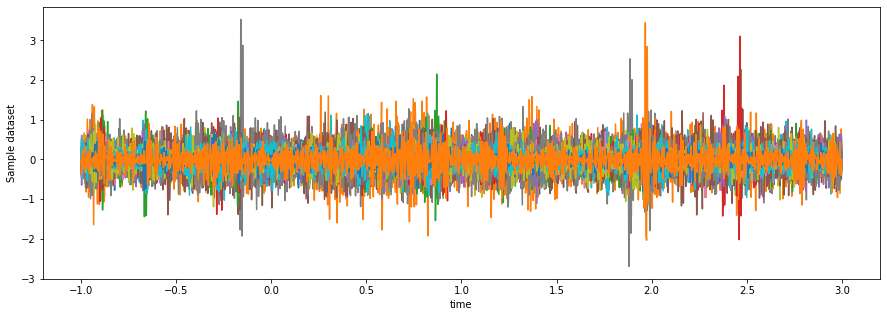

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
da_lowpass.mean(dim='epoch').plot.line(x='time')
ax.get_legend().remove()

## Calculate the envelope of this signal with `da.groupby`

Next, we'll calculate the **envelope** of the high-pass-filtered data. This is roughly
the **power** that is present in these high frequencies over time. We do so by using
something called a **hilbert transform**.

MNE also has a function for applying Hilbert transforms to data, but it has a weird quirk
that expects the data to be of a particular shape. We can work around this by using our
DataArray's `groupby` method. This works similar to `DataFrame.groupby` - we'll iterate
through each channel, which will return a DataArray with shape `epochs x timepoints`.
We can then calculate the Hilbert transform in each and re-combine into the original shape.

**Note**: This can be an expensive operation depending on the number of channels/epochs and
the length of each trial. This might be a good place to insert paralellization via Dask.

In [29]:
def hilbert_2d(array):
    """Perform a Hilbert transforms on an (n_channels, n_times) array."""
    for ii, channel in enumerate(array):
        array[ii] = mne.filter._my_hilbert(channel, envelope=True)
    return array

da_hf_power = da_lowpass.groupby(da.coords['epoch']).apply(hilbert_2d)

The output dataarray should be the exact same shape, because we haven't done any dimensional reductions.
If we take a look at the resulting data, we can see what seems to be more structure in there:

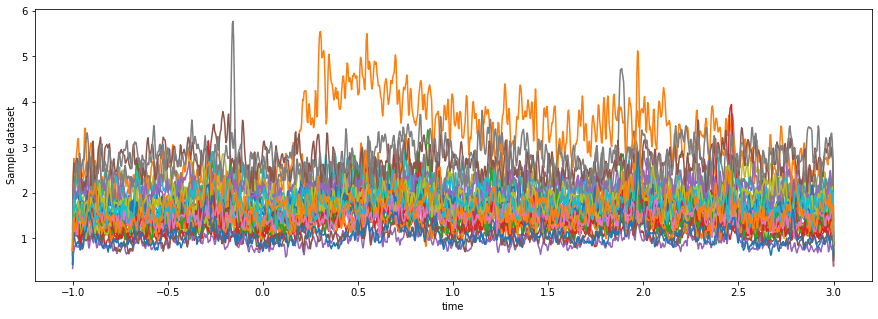

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
da_hf_power.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

# Cleaning up our HFA data

Next let's clean up this high-frequency activity (HFA) data.

## Z-scoring our array

Instead of simple de-meaning
the data like before, we'll **re-scale** our data using the same baseline timepoints.
What we'd like to do is the following:

* Calculate the mean and standard deviation across trials of all pre-baseline data values, per channel
* Z-score each channel using this mean and standard deviation

Once again we'll use the groupby / apply combination to apply our function to subsets
of the data.

In [31]:
# For each channel, apply a z-score that uses the mean/std of pre-baseline activity for all trials
def z_score(activity):
    """Take a DataArray and apply a z-score using the baseline"""
    baseline = activity.where(activity.time < -.1 )
    return (activity - np.nanmean(baseline)) / np.nanstd(baseline)

da_hf_zscored = da_hf_power.groupby('channel').apply(z_score)

Taking a look at the result, we can see a much cleaner separation of activity for
some of the channels after `time==0`.

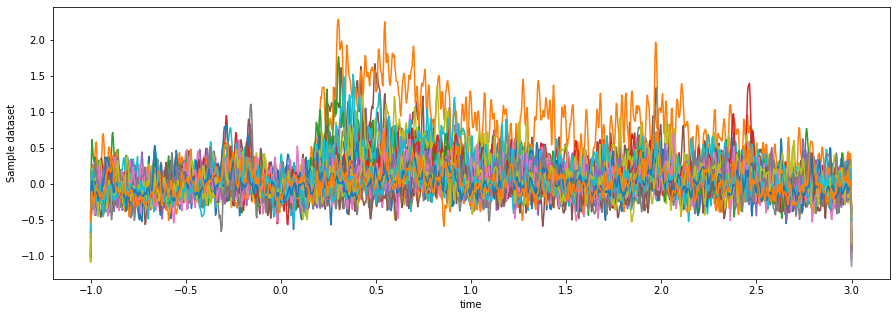

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
da_hf_zscored.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

## Smoothing our HFA data

Finally, let's smooth this HFA so it has less jitter to it, and pick a smaller window that
removes some of the filtering artifacts at the edges.

We'll use the same `filter_data` function as before, but this time
applied with the `.groupby` and `.apply` combination to show two ways
of accomplishing the same thing. We'll also use `.sel` to pick a subset
of time for visualization

In [33]:
da_hf_zscored_lowpass = da_hf_zscored.groupby('epoch').apply(
    mne.filter.filter_data,
    sfreq=da.sfreq,
    l_freq=None,
    h_freq=10,
    verbose=False
)

Note that quickly selecting a subset of timepoints if we used numpy is much more verbose. Here's
a quick comparison:

```python
# Numpy alone
mask_time = (times > -.8) * (times < 2.8)
epoch_dim = 0
da_hf_zscored_lowpass[..., mask_time].mean(epoch_dim)

# xarray
da_hf_zscored_lowpass.sel(time=slice(-.8, 2.8)).mean(dim='epoch')
```

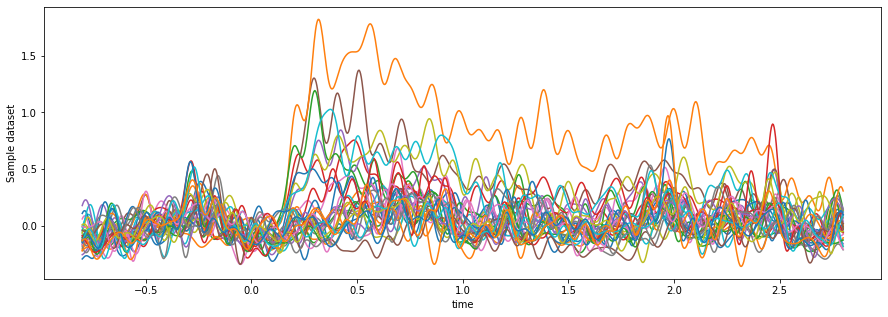

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
da_hf_zscored_lowpass.mean(dim='epoch').sel(time=slice(-.8, 2.8)).plot.line(x='time', hue='channel')
ax.get_legend().remove()

Now we can see there are clearly some channels that become active just after `t==0`.
We can reduce our dataarray to a single dimension of "mean post-baseline activity in each channel"
and convert it to a DataFrame for further processing:

In [35]:
# Find the channel with the most activity by first converting to a dataframe
total_activity = da_hf_zscored_lowpass.sel(time=slice(0, 2)).mean(dim=['epoch', 'time'])
total_activity = total_activity.to_dataframe()
total_activity.head()

,Sample dataset
channel,
ch_0,0.011101
ch_1,0.012152
ch_2,0.051911
ch_3,0.176188
ch_4,0.246021


Let's grab the channel with maximal activation to look into a bit further.

In [36]:
max_chan = total_activity.squeeze().sort_values(ascending=False).index[0]

# Time frequency analysis

As a final step, let's **expand** our DataArray and add another dimension.
In the above steps we specifically focused on high-frequency activity. A more
common approach is to first create a **spectrogram** of your data to see activity
across many frequencies.

To do this, we'll use another MNE function for creating a **Time-Frequency Representation**
or TFR. We'll define a range of frequencies, and apply MNE's function *directly on our DataArray*.
This will return a NumPy array with the filtered values.

In [37]:
frequencies = [2**ii for ii in np.arange(2, 9, .5)]
tfr = mne.time_frequency.tfr_array_morlet(
    da,
    sfreq=da.sfreq,
    freqs=frequencies,
    n_cycles=4,
)

# Take the absolute value to throw out the non-real parts of the numbers
tfr = np.abs(tfr)
tfr[:2, :2, :2, :2]

array([[[[160.04103045, 160.38413909],
         [171.73704543, 175.09249553]],

        [[283.28699104, 285.21855726],
         [241.65630528, 245.77098295]]],


       [[[ 93.99546124,  94.4406537 ],
         [ 78.02050045,  79.15324341]],

        [[ 47.85148993,  49.90845151],
         [ 53.97221461,  54.55793674]]]])

## Convert this data into a DataArray with `.expand_dims`

Next, we'll convert this into a DataArray by using the metadata from our original
DataArray. We can use the `expand_dims` method to create a new dimension for our DataArray.
We'll use this to store frequency information.

We'll then reshape our new DataArray so that it matches the output of the MNE function,
and use the `copy` method to create a new DataArray. By supplying the `data=` argument
to copy, we directly insert the new data inside the generated DataArray.

In [38]:
da_tfr = (da
    .expand_dims(frequency=frequencies)
    .transpose('epoch', 'channel', 'frequency', 'time')
    .copy(data=np.log(tfr))
)

We can now visualize this time-frequency representation over time

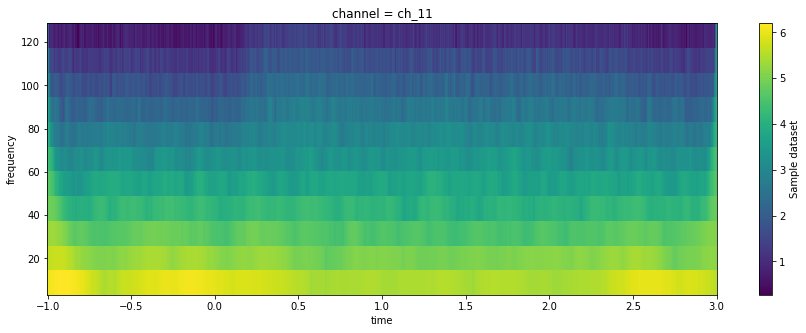

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
(da_tfr
    .sel({'frequency': slice(None, 180), 'channel': max_chan})
    .mean('epoch')
    .plot.imshow(x='time', y='frequency')
)

Similar to our one-dimensional visualizations above, it can be hard to visualize
relative changes in activity over a baseline (particularly because the amplitude scales
inversely with the frequency).

Let's apply a re-scaling function to our data so that
we can see things more clearly. This time we'll use MNE's `rescale` function, which
acts similarly to our `zscore` function above.

In [40]:
da_tfr_baselined = xr.apply_ufunc(
    mne.baseline.rescale,
    da_tfr,
    kwargs={'times': da_tfr.coords['time'], 'baseline': (None, -.1), "mode": 'zscore'}
)

Applying baseline correction (mode: zscore)


again, the result should be a DataArray, so we can directly visualize it:

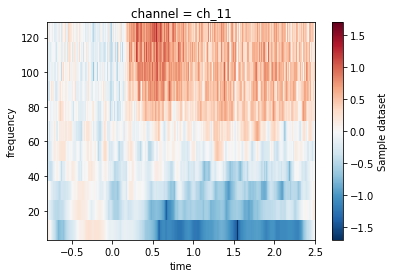

In [41]:
(da_tfr_baselined
    .sel({'frequency': slice(None, 180), 'channel': max_chan, 'time': slice(-.8, 2.5)})
    .mean('epoch')
    .plot.imshow(x='time', y='frequency')
)

Now we can see a clear increase in activity in the higher frequencies at `t==0`.

# Combining the two with `xr.merge`

Finally, let's combine these two DataArrays into one. We know that they
share much of the same metadata - the first is "Amplitude of High-Frequency Activity"
and the second is "Time-frequency power". We should be able to merge these
into a single xarray `DataSet`, which will allow us to perform operations across
both by using their shared dimensions. DataSets are kind of like collections of
DataArrays, with assumptions that the DataArrays share some metadata or coordinates.

First, we'll rename each DataArray so that we can merge them nicely. Then, we'll simply
use the `xr.merge` function, which tries to automatically figure out which dimensions are
shared based on their names and coordinate values.

In [43]:
da_tfr_baselined.name = "Time Frequency Representation"
da_hf_zscored_lowpass.name = "Low-pass filtered HFA"
ds = xr.merge([da_tfr_baselined, da_hf_zscored_lowpass])
ds

<xarray.Dataset>
Dimensions:                        (channel: 32, epoch: 29, frequency: 14, time: 1201)
Coordinates:
  * frequency                      (frequency) float64 4.0 5.657 ... 256.0 362.0
  * time                           (time) float64 -1.0 -0.9967 ... 2.997 3.0
  * channel                        (channel) <U5 'ch_0' 'ch_1' ... 'ch_31'
  * epoch                          (epoch) int64 0 1 2 3 4 5 ... 24 25 26 27 28
Data variables:
    Time Frequency Representation  (epoch, channel, frequency, time) float64 -1.068 ... 1.231
    Low-pass filtered HFA          (epoch, channel, time) float64 -0.5572 ... -0.7839

Since we've got a single dataset, we can grab subsets along each axis across both
DataArrays at the same time. We'll select a subset of channels, time, and frequency bands
to visualize.

In [44]:
ds_plt = ds.sel({'channel': max_chan, 'frequency': slice(10, 150), 'time': slice(-.5, 2)})

Now, we'll plot **both** the spectrogram and the HFA in the same Matplotlib figure. As you
can see, these plots contain somewhat redundant information. The top plot tells us that there is
a general increase in power for high-frequencies. The bottom plot gives us the average increase in
power across the higher frequencies.

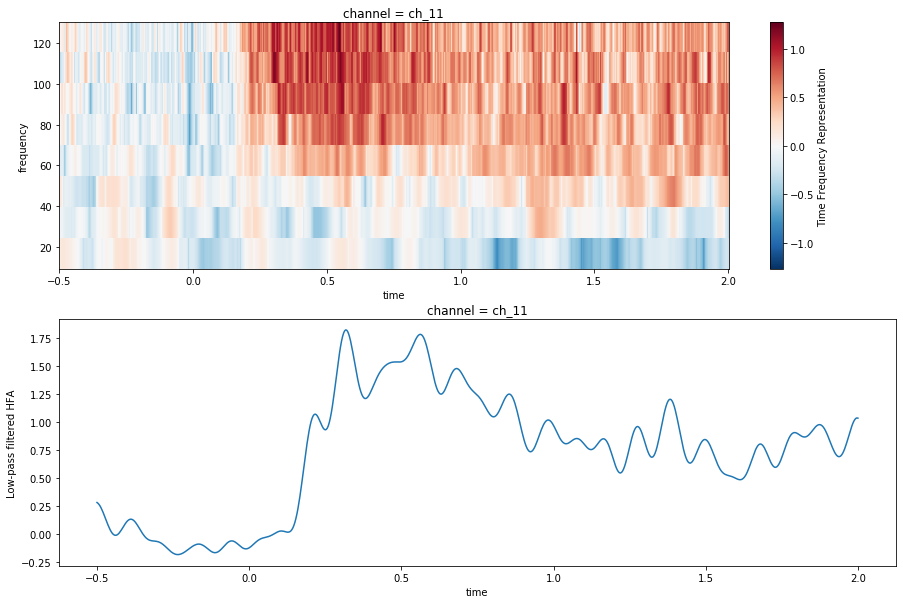

In [45]:
fig, (ax_tfr, ax_hfa) = plt.subplots(2, 1, figsize=(15, 10))
im = ds_plt['Time Frequency Representation'].mean('epoch').plot.imshow(x='time', y='frequency',
                                                                       ax=ax_tfr)

ds_plt['Low-pass filtered HFA'].mean('epoch').plot.line(x='time', ax=ax_hfa)

# Wrapping up

In all, I was pretty happy with what you can do using xarray's `DataArray` structure.
It's pretty nice to be able to refer to axes by their names, and to make more intelligent
selection / slicing operations using their coordinate values. Moreover, this post is just
scratching the surface for how to use this information in a way that speeds up the exploration
and analysis post.

For example, we might have sped-up some feature extraction steps by using
a distributed processing framework like **Dask** in the operations above. Dask integrates nicely
with xarray, and offers a lot of interesting opportunities to parallelize interactive computation.
I'll explore that in another blog post.

Finally - the goal of this post has largely been to learn a bit more about xarray. This means I might
be totally mis-using functionality, or missing something that would have made the above process much
easier. If anybody has tips or thoughts on the code above, please do reach out!